In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
# Чтение данных
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### Описание ДатаСета

* recency - кол-во месяцев с момента последней покупки
* history - стоимость покупок в долларах США
* used_discount - указывает, использовал ли клиент скидку ранее
* used_bogo - указывает, использовал ли клиент услугу "купи и получи" раньше
* zip_code - класс почтового индекса как Пригородный/Городской/Сельский
* is_referral - указывает, был ли клиент приобретен по реферальному каналу
* channel - связь, которую использует клиент, Телефон / Интернет /Многоканальный
* treatment - предложения, отправленные клиентам, Скидка /Купи одно, Получи одно / Либо Нет предложения
* target - customer conversion (buy or not) - конверсия (купил клиент или не совершил покупок)


In [3]:
class DataPreprocessing:
    """Preparation of initial data"""

    def __init__(self):
        self.medians = None

    def fit(self, X, y=None):
        self.medians = X.median(numeric_only=True)
        return self

    def transform(self, X, y=None):
        X.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
        X.fillna(self.medians, inplace=True)
        return X

In [4]:
preprocessor = DataPreprocessing()
preprocessor.fit(df)

df = preprocessor.transform(df)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
class FeatureGenetator():
    """Generation of new features"""

    def __init__(self):
        self.cat_to_numbers = None

    def fit(self, X, y=None):
        # Categorical features
        self.cat_to_numbers = {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}

    def transform(self, X, y=None):
        X.insert(0, "ID", X.index.tolist())

        # Categorical features
        X['treatment'] = X['treatment'].map(self.cat_to_numbers)

        # Dummies features
        for cat_colname in X.select_dtypes(include='object').columns[0:]:
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
            X = X.drop([cat_colname], axis=1)

        return X

In [6]:
features_gen = FeatureGenetator()
features_gen.fit(df)

df = features_gen.transform(df)
df.head(3)

,ID,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,2,7,180.65,0,1,1,1,0,0,1,0,0,0,1


In [7]:
# разделим данные на train/test
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(df, df[['treatment','target']], test_size=0.25, random_state=0)

In [8]:
X_data_train = X_data_train.drop(['treatment', 'target'], axis=1)
X_data_test = X_data_test.drop(['treatment', 'target'], axis=1)

In [9]:
indices_train = X_data_train.index
indices_test = X_data_test.index
indices_learn, indices_valid = train_test_split(indices_train, test_size=0.3, random_state=123)

In [10]:
X_train = X_data_train.loc[indices_learn, :]
X_train = X_train.drop(['ID'], axis=1)
y_train = y_data_train.loc[indices_learn, 'target']
treat_train = y_data_train.loc[indices_learn, 'treatment']

In [11]:
X_val = X_data_train.loc[indices_valid, :]
y_val = y_data_train.loc[indices_valid, 'target']
treat_val =  y_data_train.loc[indices_valid, 'treatment']

In [12]:
X_test = X_data_test

In [13]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': [],
    'uplift@40%': [],
    'uplift@50%': []
}

In [14]:
X_test = X_test.drop(['ID'], axis=1)
X_val = X_val.drop(['ID'], axis=1)
# X_test

In [15]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


## uplift-моделирование

### 1.1 S-learner

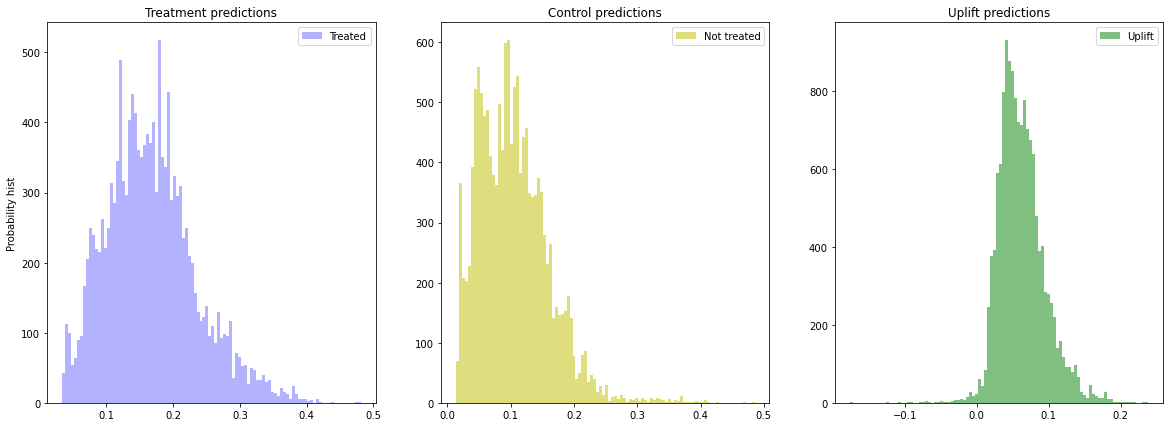

In [16]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

models_results['approach'].append('SoloModel')

for el in [10,20,30,40,50]:
    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=el/100)
    models_results['uplift@' + str(el) + '%'].append(sm_score)
    
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### топ-признаки датасета

In [17]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,16.894775
1,history,16.179138
2,recency,15.072062
3,treatment,14.146180
4,used_bogo,11.896204
5,used_discount,7.363323
6,zip_code_Rural,6.099042
7,channel_Web,5.786973
8,channel_Phone,2.165736
9,zip_code_Urban,1.893125


In [18]:
sm_score

0.07670673612607587

### Метрики

#### uplift@k

$$uplift@k = response\space rate@k_{treatment} - response\space  rate@k_{control}$$ 
$$response\space  rate@k = mean(Y@k)$$


Размер uplift на топ k процентах выборки.



In [19]:
n = 100
df_m = pd.DataFrame({
    'true': y_val[:n],
    'uplift': uplift_sm[:n],
    'treat': treat_val[:n]
})   
df_m.head(5) 

,true,uplift,treat
10325,1,0.054270,0
8713,0,0.048854,1
30635,0,0.035618,1
5826,0,0.067403,1
42507,0,0.029617,0


**strategy='overall'**

In [20]:
k = 0.7

uplift_at_k(y_true=df_m['true'], uplift=df_m['uplift'], treatment=df_m['treat'],
            # strategy='by_group',
            strategy='overall',
            k=k)

-0.0632630410654828

In [21]:
df_k = df_m.sort_values(by='uplift', ascending=False).head(int(n * k))
df_k

,true,uplift,treat
23813,1,0.180080,1
26259,0,0.139551,1
40781,0,0.139448,1
60140,0,0.122365,1
891,0,0.114926,0
...,...,...,...
8713,0,0.048854,1
6009,1,0.047753,1
43474,0,0.047400,1
21359,0,0.046929,0


In [22]:
response_rate_treat = df_k[(df_k.treat == 1)].true.mean()
response_rate_control = df_k[(df_k.treat == 0)].true.mean()
response_rate_treat - response_rate_control

-0.0632630410654828

**strategy='by_group'**

In [23]:
k = 4
uplift_at_k(y_true=df_m['true'], uplift=df_m['uplift'], treatment=df_m['treat'],
            strategy='by_group',
            # strategy='overall',
            k=k)

0.25

In [24]:
df_k_treat = df_m[df_m.treat == 1]
df_k_treat = df_k_treat.sort_values(by='uplift', ascending=False).head(k)

df_k_control = df_m[df_m.treat == 0]
df_k_control = df_k_control.sort_values(by='uplift', ascending=False).head(k)

df_k_treat

,true,uplift,treat
23813,1,0.180080,1
26259,0,0.139551,1
40781,0,0.139448,1
60140,0,0.122365,1


In [25]:
df_k_control

,true,uplift,treat
891,0,0.114926,0
27683,0,0.094309,0
4748,0,0.094039,0
61709,0,0.081100,0


In [26]:
response_rate_treat = df_k_treat.true.mean()
response_rate_control = df_k_control.true.mean()
response_rate_treat - response_rate_control

0.25

##### Uplift curve

$$uplift \space curve(t) = (\frac{Y^T_t}{N^T_t} - \frac{Y^C_t}{N^C_t})(N^T_t + N^C_t) $$
$t$ - накопившиеся количество объектов<br>
$Y^T_t, Y^C_t$ - таргет в treatment и control группах<br>
$N^T_t, N^C_t$ - размер treatment и control групп<br>


Uplift кривая строится как функция от количества объектов, нарастающим итогом. В каждой точке кривой можно увидеть накопленный к этому моменту uplift

На картинке ниже расположен типичный график идеальной, модельной и случайной кривых. Каждая точка на такой кривой соответствует значению кумулятивного uplift. Чем больше это значение, тем лучше. Монотонно возрастающая случайная кривая показывает, что воздействие всей выборки имеет общий положительный эффект. 

In [27]:
from sklift.viz import plot_uplift_curve

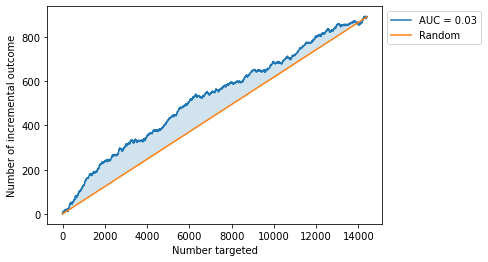

In [28]:
# with ideal curve
# perfect=True
plot_uplift_curve(
    y_val, uplift_sm, treat_val, 
    # perfect=True,
    perfect=False
);

##### Qini curve
Еще одной довольно распространенной кривой при оценке uplift моделей является Qini кривая.

$$qini\ curve (t) = Y^T_t - \frac{Y^C_t N^T_t}{N^C_t}$$

$Y^T_t, Y^C_t$ - таргет в treatment и control группе<br>
$N^T_t, N^C_t$ - размер treatment и control групп



Qini curve, как и другие аплифт метрики, рассчитывается кумулятивно сразу для набора объектов. Кривую Qini для модели тоже сравнивают со случайной кривой и с идеальным случаем. Аналогично с uplift кривой, чем выше кривая над случайной кривой, тем лучше. 

In [29]:
from sklift.viz import plot_qini_curve

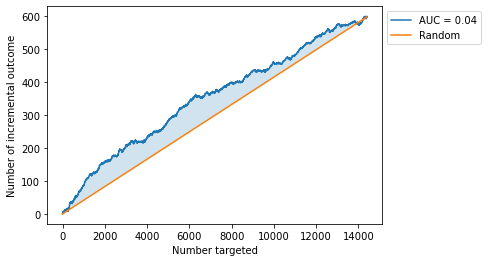

In [30]:
# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(
    y_val, uplift_sm, treat_val,
    # perfect=True
    perfect=False
);

In [31]:
from sklift.metrics import qini_auc_score


# коэффициент qini, или area under qini curve (AUQC)
auqc = qini_auc_score(y_val, uplift_sm, treat_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0417


##### Uplift by percentile


In [32]:
from sklift.metrics import uplift_by_percentile

# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_val, uplift_sm,  treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,962,478,0.261954,0.133891,0.128063,0.014176,0.015576,0.021061
10-20,943,497,0.200424,0.124748,0.075676,0.013036,0.014822,0.019739
20-30,954,486,0.184486,0.125514,0.058972,0.012558,0.015028,0.019584
30-40,996,444,0.188755,0.110360,0.078395,0.012399,0.014870,0.019362
40-50,965,475,0.165803,0.122105,0.043698,0.011972,0.015022,0.019209
50-60,986,454,0.147059,0.096916,0.050143,0.011279,0.013885,0.017888
60-70,942,498,0.143312,0.102410,0.040902,0.011416,0.013586,0.017746
70-80,969,471,0.137255,0.072187,0.065068,0.011055,0.011925,0.016260
80-90,990,450,0.140404,0.084444,0.055960,0.011041,0.013108,0.017138


Если визуализировать таблицу, то получится график uplift by percentile. По нему удобно оценивать эффективность модели. 

Так как коммуникация будет проводиться с клиентами, получившими наибольшую оценку uplift, то слева на графике должны быть максимальные по модулю положительные значения uplift и в следующих перцентилях значения уменьшаются.

J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


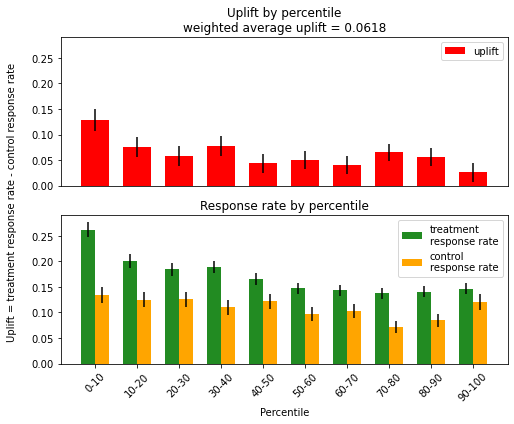

In [33]:
from sklift.viz import plot_uplift_by_percentile

# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar'); # line



В левой части графика находятся убеждаемые — тот тип, которых мы хотим найти.

В терминах целевого действия и коммуникации это Y=1 при W=1 и Y=0 при W=0.

##### Weighted average uplift
С помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, взвешенный на размер целевой группы - weighted average uplift 

In [34]:
from sklift.metrics import weighted_average_uplift

# с помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, 
# взвешенный на размер целевой группы — weighted average uplift
uplift_full_data = weighted_average_uplift(y_val, uplift_sm, 
                                            treat_val, bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0623


### 1.2 Трансформация классов


In [35]:
from sklift.models import ClassTransformation


ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

models_results['approach'].append('ClassTransformation')

for el in [10,20,30,40,50]:
    ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=el/100)
    models_results['uplift@' + str(el) + '%'].append(ct_score)

In [36]:
ct_score

0.08126490044546193

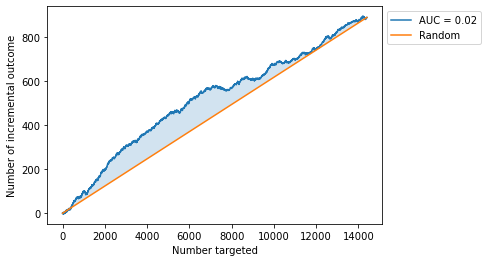

In [37]:
from sklift.viz import plot_uplift_curve


# with ideal curve
# perfect=True
plot_uplift_curve(
    y_val, uplift_ct, treat_val, 
    # perfect=True
    perfect=False
);

J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


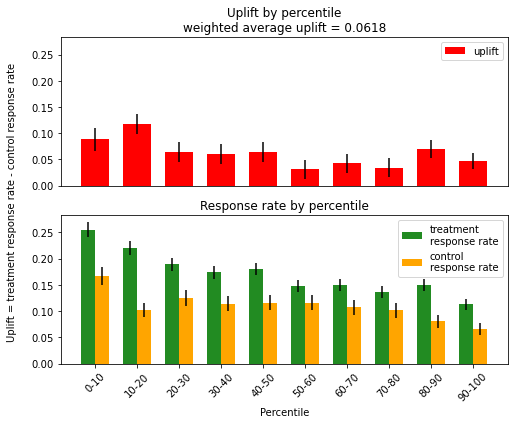

In [38]:
# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_ct, treat_val, 
                          strategy='overall', kind='bar'); # line

### 1.2 Две независимые модели


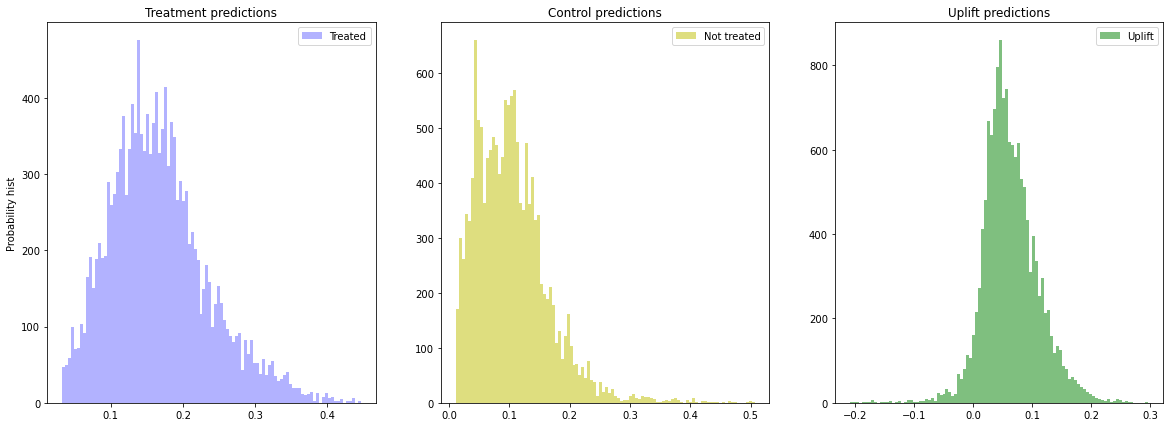

In [39]:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

models_results['approach'].append('TwoModels')

for el in [10,20,30,40,50]:
    tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=el/100)
    models_results['uplift@' + str(el) + '%'].append(tm_score)
    
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### Итоговая таблица по моделям/uplift@k%

In [40]:
df_score = pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)
df_score

,approach,uplift@10%,uplift@20%,uplift@30%,uplift@40%,uplift@50%
1,ClassTransformation,0.087022,0.103359,0.090308,0.082552,0.081265
2,TwoModels,0.108259,0.079464,0.087356,0.084853,0.079956
0,SoloModel,0.125007,0.101932,0.084483,0.084201,0.076707


#### Посмотрим результаты по моделям на графиках

Solo Model


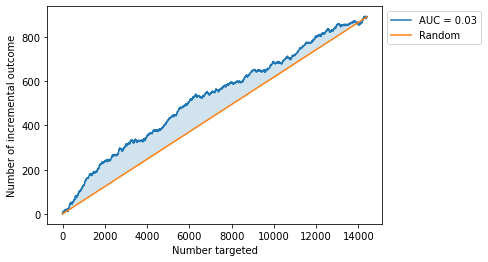

ClassTransform Model


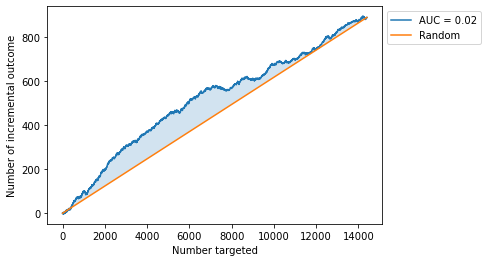

Two Model


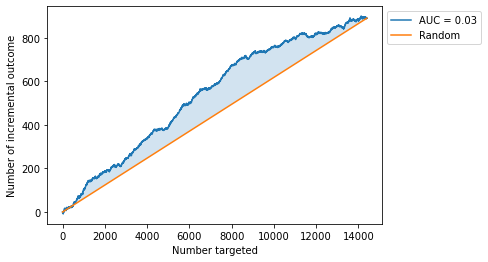

In [41]:
import matplotlib.pyplot as plt

print('Solo Model')
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()

### 7. Прогноз и uplift для тестовой выборки

### 7.1 Модель трансформация классов для тестовой выборки


In [63]:
models_results_test = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': [],
    'uplift@40%': [],
    'uplift@50%': []
}

In [44]:
y_test = y_data_test['target']
treat_test =  y_data_test['treatment']

In [64]:
uplift_ct_test = ct.predict(X_test)

models_results_test['approach'].append('ClassTransformation')

for el in [10,20,30,40,50]:
    ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct_test, treatment=treat_test, strategy='by_group', k=el/100)
    models_results_test['uplift@' + str(el) + '%'].append(ct_score)

In [65]:
df_test = pd.DataFrame({
    'true': y_test,
    'uplift': uplift_ct_test,
    'treat': treat_test
})   
df_test.head()

,true,uplift,treat
11277,1,-0.232676,1
55819,0,-0.037052,1
43223,0,-0.013464,1
1351,0,-0.218336,1
9247,0,-0.113631,0


In [66]:
k = 0.7

uplift_at_k(y_true=df_test['true'], uplift=df_test['uplift'], treatment=df_test['treat'],
            # strategy='by_group',
            strategy='overall',
            k=k)

0.05307343040222838

In [67]:
df_test_k = df_test.sort_values(by='uplift', ascending=False)
df_test_k.head(10)

,true,uplift,treat
45460,0,0.363791,1
25099,0,0.272973,1
40582,0,0.270313,0
36676,0,0.270313,0
32480,0,0.270313,0
30652,0,0.239429,0
46723,0,0.239429,1
42271,0,0.217830,1
22419,0,0.210377,1
1220,0,0.190824,1


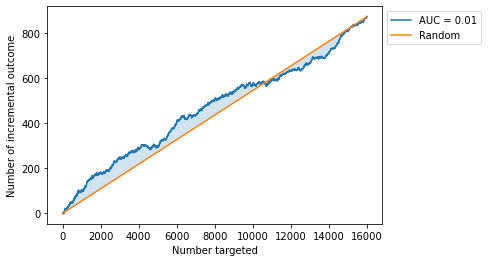

In [68]:
# with ideal curve
# perfect=True
plot_uplift_curve(
    y_test, uplift_ct_test, treat_test, 
    # perfect=True,
    perfect=False
);

In [69]:
# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_test, uplift_ct_test, treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1064,536,0.242481,0.143657,0.098824,0.013139,0.015150,0.020054
10-20,1070,530,0.198131,0.141509,0.056621,0.012185,0.015140,0.019434
20-30,1070,530,0.164486,0.130189,0.034297,0.011333,0.014617,0.018496
30-40,1100,500,0.188182,0.108000,0.080182,0.011785,0.013881,0.018209
40-50,1068,532,0.153558,0.109023,0.044535,0.011032,0.013513,0.017444
50-60,1082,518,0.146950,0.111969,0.034981,0.010764,0.013855,0.017544
60-70,1069,531,0.136576,0.112994,0.023582,0.010503,0.013739,0.017293
70-80,1059,541,0.130312,0.088725,0.041587,0.010345,0.012225,0.016015
80-90,1059,541,0.132200,0.083179,0.049021,0.010408,0.011873,0.015789


J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


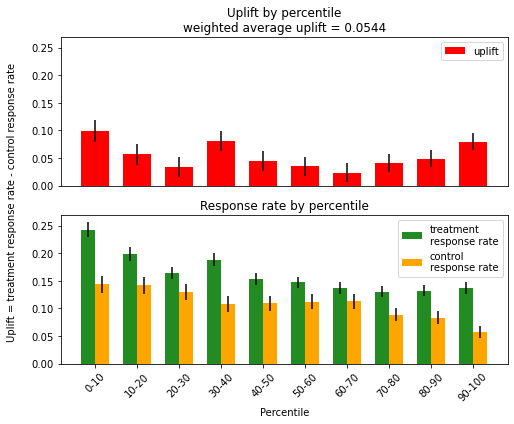

In [70]:
plot_uplift_by_percentile(y_test, uplift_ct_test, treat_test, 
                          strategy='overall', kind='bar'); # line

### 7.2 S-learner для тестовой выборки


In [71]:
uplift_sm_test = sm.predict(X_test)

models_results_test['approach'].append('SoloModel')

for el in [10,20,30,40,50]:
    sm_score_test = uplift_at_k(y_true=y_test, uplift=uplift_sm_test, treatment=treat_test, strategy='by_group', k=el/100)
    models_results_test['uplift@' + str(el) + '%'].append(sm_score_test)

In [72]:
df_test_sm = pd.DataFrame({
    'true': y_test,
    'uplift': uplift_sm_test,
    'treat': treat_test
})   
df_test_sm.head()

,true,uplift,treat
11277,1,0.059355,1
55819,0,0.095054,1
43223,0,0.089484,1
1351,0,0.038149,1
9247,0,0.069709,0


In [73]:
k = 0.7

uplift_at_k(y_true=df_test_sm['true'], uplift=df_test_sm['uplift'], treatment=df_test_sm['treat'],
            # strategy='by_group',
            strategy='overall',
            k=k)

0.05679836759772591

In [74]:
df_test_sm_k = df_test_sm.sort_values(by='uplift', ascending=False)
df_test_sm_k.head(10)

,true,uplift,treat
40348,1,0.227035,1
44151,1,0.217821,1
61866,0,0.213715,0
51323,0,0.212851,0
7837,0,0.210576,0
54748,1,0.205890,1
7710,1,0.205179,1
36314,0,0.204519,0
41178,0,0.202683,0
46913,0,0.198489,0


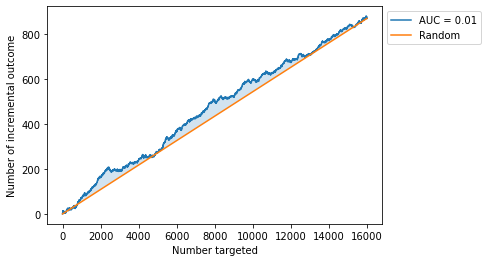

In [75]:
# with ideal curve
# perfect=True
plot_uplift_curve(
    y_test, uplift_sm_test, treat_test, 
    # perfect=True,
    perfect=False
);

In [76]:
# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_test, uplift_sm_test, treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1054,546,0.221063,0.146520,0.074542,0.012782,0.015134,0.019809
10-20,1076,524,0.188662,0.133588,0.055074,0.011927,0.014862,0.019056
20-30,1076,524,0.162639,0.131679,0.030960,0.011250,0.014772,0.018568
30-40,1074,526,0.189944,0.098859,0.091085,0.011969,0.013014,0.017681
40-50,1094,506,0.159963,0.090909,0.069054,0.011083,0.012780,0.016916
50-60,1053,547,0.146249,0.098720,0.047529,0.010889,0.012754,0.016770
60-70,1062,538,0.127119,0.096654,0.030464,0.010222,0.012739,0.016333
70-80,1082,518,0.142329,0.100386,0.041943,0.010622,0.013204,0.016946
80-90,1070,530,0.145794,0.084906,0.060889,0.010788,0.012108,0.016217


J:\Vadim\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


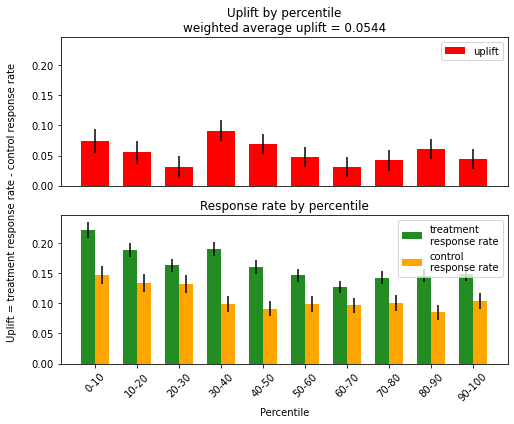

In [77]:
plot_uplift_by_percentile(y_test, uplift_sm_test, treat_test, 
                          strategy='overall', kind='bar'); # line

In [79]:
df_score_test = pd.DataFrame(data=models_results_test).sort_values('uplift@30%', ascending=False)
df_score_test

,approach,uplift@10%,uplift@20%,uplift@30%,uplift@40%,uplift@50%
0,ClassTransformation,0.102639,0.076326,0.062355,0.065225,0.062561
1,SoloModel,0.073588,0.063768,0.053052,0.061795,0.062439


In [80]:
groups = ['Gr_0', 'Gr_1', 'Gr_2', 'Gr_3', 'Gr_4', 'Gr_5', 'Gr_6', 'Gr_7', 'Gr_8', 'Gr_9']

In [81]:
pd.qcut(df_test_sm_k['uplift'], 10)

40348      (0.103, 0.227]
44151      (0.103, 0.227]
61866      (0.103, 0.227]
51323      (0.103, 0.227]
7837       (0.103, 0.227]
               ...       
35967    (-0.183, 0.0276]
28380    (-0.183, 0.0276]
39936    (-0.183, 0.0276]
61936    (-0.183, 0.0276]
22873    (-0.183, 0.0276]
Name: uplift, Length: 16000, dtype: category
Categories (10, interval[float64, right]): [(-0.183, 0.0276] < (0.0276, 0.0365] < (0.0365, 0.0437] < (0.0437, 0.0504] ... (0.0663, 0.075] < (0.075, 0.0852] < (0.0852, 0.103] < (0.103, 0.227]]

In [82]:
df_test_sm['relevance_of_contact'] = pd.qcut(df_test_sm['uplift'], q=10, labels=groups)
df_test_sm.head(20)

,true,uplift,treat,relevance_of_contact
11277,1,0.059355,1,Gr_5
55819,0,0.095054,1,Gr_8
43223,0,0.089484,1,Gr_8
1351,0,0.038149,1,Gr_2
9247,0,0.069709,0,Gr_6
46551,0,0.054245,0,Gr_4
8209,0,0.062650,1,Gr_5
27633,0,0.044172,1,Gr_3
51794,1,0.066029,0,Gr_5
38249,0,0.044992,0,Gr_3
